## Ensemble Method

In [ ]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [20]:
#Loading KNN Models
knn_pm25 = joblib.load("data/model/knn_pm2.5.joblib", mmap_mode ='r')
knn_no2 = joblib.load("data/model/knn_no2.joblib", mmap_mode ='r')

In [40]:
#Loading Forecasting Models 
model_co = load_model('data/model/simple_rnn_co.rnn')
model_o3 = load_model('data/model/simple_rnn_o3.rnn')
model_so2 = load_model('data/model/simple_rnn_so2.rnn')
model_temp = load_model('data/model/simple_rnn_temp.rnn')
model_dewp = load_model('data/model/simple_rnn_dewp.rnn')
model_pres = load_model('data/model/simple_rnn_pres.rnn')
model_wspm = load_model('data/model/simple_rnn_wspm.rnn')
baseline_model_no2 = load_model('data/model/simple_rnn_no2.rnn')
baseline_model_pm25 = load_model('data/model/simple_rnn_pm25.rnn')

In [4]:
dataset = joblib.load('data/cleaned/unnormalized_Wanshouxigong.joblib')

In [5]:
test_set = dataset[28000:]
test_set = test_set[['PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP']]

In [25]:
def build_scaler(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    return scaler

def prepare(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    X = values[:-1]
    y = values[1:]
    
    return X, y

def get_scaler(dataset, feature_col="SO2"):
    dataset = dataset[[feature_col]]
    series = dataset[feature_col].values
    values = series.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values = scaler.fit_transform(values)
    return scaler
    
def rebuild_dataframe(scalers, values, cols):
    df = pd.DataFrame()
    for idx, value in enumerate(values):
        df[cols[idx]] = scalers[idx].inverse_transform(value).flatten()
        
    return df

def reshape(sequence):
    return sequence.reshape(sequence.shape[0], sequence.shape[1], 1)

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))

In [41]:
# Preparing Vectors
X_o3, y_o3 = prepare(test_set, "O3")
X_so2, y_so2 = prepare(test_set, "SO2")
X_co, y_co = prepare(test_set, "CO")
X_temp, y_temp = prepare(test_set, "TEMP")
X_pres, y_pres = prepare(test_set, "PRES")
X_dewp, y_dewp = prepare(test_set, "DEWP")
X_no2, y_no2 = prepare(test_set, "NO2")
X_pm25, y_pm25 = prepare(test_set, "PM2.5")

In [42]:
# Reshaping
X_o3 = reshape(X_o3)
X_so2 = reshape(X_so2)
X_co = reshape(X_co)
X_temp = reshape(X_temp)
X_pres = reshape(X_pres)
X_dewp = reshape(X_dewp)
X_no2 = reshape(X_no2)
X_pm25 = reshape(X_pm25)

In [44]:
# Getting Predictions

predicted_o3 = model_o3.predict(X_o3)
#predicted_o3 = np.reshape(predicted_o3, (predicted_o3.size,))

predicted_so2 = model_so2.predict(X_so2)
#predicted_so2 = np.reshape(predicted_so2, (predicted_so2.size,))

predicted_co = model_co.predict(X_co)
#predicted_co = np.reshape(predicted_co, (predicted_co.size,))

predicted_temp = model_temp.predict(X_temp)
#predicted_temp = np.reshape(predicted_temp, (predicted_temp.size,))

predicted_dewp = model_dewp.predict(X_dewp)
#predicted_dewp = np.reshape(predicted_dewp, (predicted_dewp.size,))

predicted_pres = model_pres.predict(X_pres)
#predicted_pres = np.reshape(predicted_pres, (predicted_pres.size,))

In [16]:
scaler_o3 = get_scaler(dataset, feature_col="O3")
scaler_co = get_scaler(dataset, feature_col="CO")
scaler_so2 = get_scaler(dataset, feature_col="SO2")
scaler_temp = get_scaler(dataset, feature_col="TEMP")
scaler_dewp = get_scaler(dataset, feature_col="DEWP")
scaler_pres = get_scaler(dataset, feature_col="PRES")

In [17]:
scalers = [scaler_so2, scaler_co, scaler_o3, scaler_temp, scaler_pres, scaler_dewp]
predicted = [predicted_so2, predicted_co, predicted_o3, predicted_temp, predicted_pres, predicted_dewp]
cols = ['SO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP']
predicted_df = rebuild_dataframe(scalers, predicted, cols)

In [18]:
X = predicted_df.values
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(predicted_df)

### Predicting with PM2.5

In [45]:
predicted_pm25 = knn_pm25.predict(X)

In [46]:
scaler_pm25 = get_scaler(dataset, feature_col="PM2.5")
rescaled_predicted = scaler_pm25.inverse_transform(predicted_pm25)
actual_val = test_set[['PM2.5']].values[1:]

Text(0, 0.5, 'Actual Value')

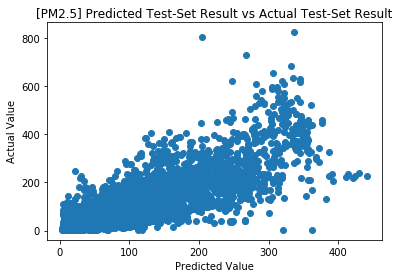

In [47]:
plt.scatter(rescaled_predicted, actual_val)
plt.title("[PM2.5] Predicted Test-Set Result vs Actual Test-Set Result")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")

In [48]:
validate_prediction(rescaled_predicted, actual_val)

'mse = 2701.86669830947 & mae = 33.14643727193489 & rmse = 51.97948343634698'

In [52]:
##Baseline Testing:
predicted_baseline_pm25 = baseline_model_pm25.predict(X_pm25)
#predicted_pres = np.reshape(predicted_pres, (predicted_pres.size,))

rescaled_predicted = scaler_pm25.inverse_transform(predicted_baseline_pm25)
actual_val = test_set[['PM2.5']].values[1:]

Text(0, 0.5, 'Actual Value')

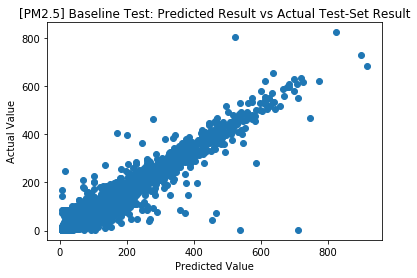

In [55]:
plt.scatter(rescaled_predicted, actual_val)
plt.title("[PM2.5] Baseline Test: Predicted Result vs Actual Test-Set Result")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")

In [54]:
validate_prediction(rescaled_predicted, actual_val)

'mse = 1188.1353763564568 & mae = 20.920791350379556 & rmse = 34.46933965651876'

### Predicting with NO2

In [64]:
predicted_no2 = knn_no2.predict(X)

In [65]:
scaler_no2 = get_scaler(dataset, feature_col="NO2")
rescaled_predicted = scaler_no2.inverse_transform(predicted_no2)
actual_val = test_set[['NO2']].values[1:]

Text(0, 0.5, 'Actual Value')

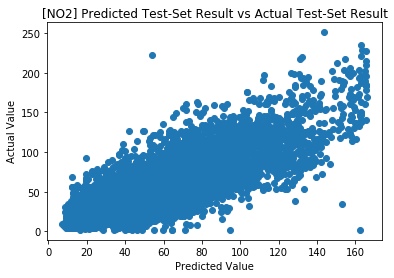

In [66]:
plt.scatter(rescaled_predicted, actual_val)
plt.title("[NO2] Predicted Test-Set Result vs Actual Test-Set Result")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")

In [67]:
validate_prediction(rescaled_predicted, actual_val)

'mse = 438.7273242832702 & mae = 15.523154406035227 & rmse = 20.945818778058552'

In [59]:
predicted_baseline_no2 = baseline_model_no2.predict(X_no2)
#predicted_pres = np.reshape(predicted_pres, (predicted_pres.size,))

In [60]:
rescaled_predicted = scaler_no2.inverse_transform(predicted_baseline_no2)
actual_val = test_set[['NO2']].values[1:]

Text(0, 0.5, 'Actual Value')

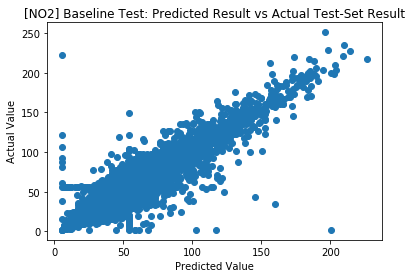

In [61]:
plt.scatter(rescaled_predicted, actual_val)
plt.title("[NO2] Baseline Test: Predicted Result vs Actual Test-Set Result")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")

In [62]:
validate_prediction(rescaled_predicted, actual_val)

'mse = 148.43233022305066 & mae = 7.478577385772324 & rmse = 12.183280765994464'